In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import kagglehub
from PIL import Image
import os


In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saharnazyaghoobpoor/happy-and-sad-image")

#print("Path to dataset files:", path)

Using Colab cache for faster access to the 'happy-and-sad-image' dataset.


In [ ]:

i=0
for root, dirs, files in os.walk(path):
    for file in files:

        i +=1

print(i)

175


In [ ]:

dataset_path = path
data_dir = os.path.join(dataset_path, "data")

if os.path.exists(data_dir):
    files_in_data = os.listdir(data_dir)
    print("Contenu du dossier data :", files_in_data)
else:
    print("Le dossier 'data' n'existe pas.")

Contenu du dossier data : ['sad', 'happy']


In [ ]:

sad_dir = os.path.join(dataset_path, "data/sad")
happy_dir = os.path.join(dataset_path, "data/happy")


sad_images = [os.path.join(sad_dir, f) for f in os.listdir(sad_dir) if f.endswith((".jpg", ".png"))]
happy_images = [os.path.join(happy_dir, f) for f in os.listdir(happy_dir) if f.endswith((".jpg", ".png"))]
print("le nombre dimages sad :", len(sad_images))
print("le nombre dimages happy :", len(happy_images))


le nombre dimages sad : 68
le nombre dimages happy : 89


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
set_seed(42)

dataset = datasets.ImageFolder(
    root=path + "/data",
    transform=transform
)

len(dataset), dataset.classes


(171, ['happy', 'sad'])

In [ ]:
import torch

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


generator = torch.Generator().manual_seed(42)

train_ds, test_ds = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)

len(train_ds), len(test_ds)

(136, 35)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


In [ ]:
class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = BetterCNN().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=2

)

In [ ]:
def accuracy(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            results = model(x)
            preds = results.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.numel()

    return correct / total

In [ ]:
set_seed(42)
epochs = 20
train_loss_values = []
test_acc_values = []
best_test_acc = 0.0
best_state = None

print(f"Entraînement lancé sur : {device}")

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy(train_loader)
    test_acc  = accuracy(test_loader)

    scheduler.step(avg_loss)




    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}


    train_loss_values.append(avg_loss)
    test_acc_values.append(test_acc)

    print(f"Epoch {epoch:02d} |  Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Best: {best_test_acc:.4f}")


if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"\nTerminé ! Meilleure Accuracy Test atteinte : {best_test_acc:.4f}")

Entraînement lancé sur : cuda
Epoch 01 |  Loss: 0.7014 | Train Acc: 0.6324 | Test Acc: 0.4571 | Best: 0.4571
Epoch 02 |  Loss: 0.6350 | Train Acc: 0.3971 | Test Acc: 0.5714 | Best: 0.5714
Epoch 03 |  Loss: 0.6241 | Train Acc: 0.7059 | Test Acc: 0.7714 | Best: 0.7714
Epoch 04 |  Loss: 0.6390 | Train Acc: 0.5221 | Test Acc: 0.6571 | Best: 0.7714
Epoch 05 |  Loss: 0.5694 | Train Acc: 0.7868 | Test Acc: 0.7714 | Best: 0.7714
Epoch 06 |  Loss: 0.5618 | Train Acc: 0.8235 | Test Acc: 0.8286 | Best: 0.8286
Epoch 07 |  Loss: 0.5231 | Train Acc: 0.8088 | Test Acc: 0.8286 | Best: 0.8286
Epoch 08 |  Loss: 0.5296 | Train Acc: 0.7647 | Test Acc: 0.7143 | Best: 0.8286
Epoch 09 |  Loss: 0.5352 | Train Acc: 0.8015 | Test Acc: 0.7143 | Best: 0.8286
Epoch 10 |  Loss: 0.4899 | Train Acc: 0.8309 | Test Acc: 0.6857 | Best: 0.8286
Epoch 11 |  Loss: 0.5259 | Train Acc: 0.8309 | Test Acc: 0.8286 | Best: 0.8286
Epoch 12 |  Loss: 0.5007 | Train Acc: 0.8456 | Test Acc: 0.7714 | Best: 0.8286
Epoch 13 |  Loss: 0.46

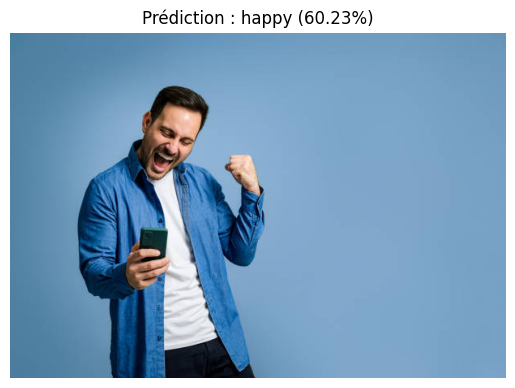

'happy'

In [ ]:
import requests
from io import BytesIO
set_seed(42)
def predict_emotion(image_path):

    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')


    img_transformed = transform(img).unsqueeze(0).to(device)


    model.eval()
    with torch.inference_mode():
        output = model(img_transformed)

        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
        confiance = probs[0][prediction].item()


    class_names = dataset.classes
    result = class_names[prediction]


    plt.imshow(img)
    plt.title(f"Prédiction : {result} ({confiance:.2%})")
    plt.axis('off')
    plt.show()

    return result


url = "https://media.istockphoto.com/id/1473323104/fr/photo/bel-homme-mid-adulte-v%C3%AAtu-dune-chemise-en-jean-hurlant-et-pompant-joyeusement-le-poing-tout.jpg?s=612x612&w=0&k=20&c=asj80xwcm_lQfWJOoEWZ8tEFLPwI1RUqRNaMnYQfC5U="
predict_emotion(url)

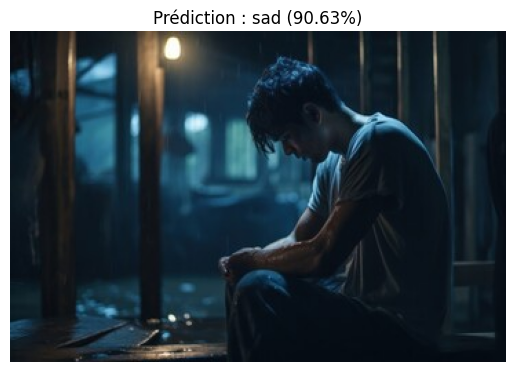

'sad'

In [ ]:
import requests
from io import BytesIO
set_seed(42)
def predict_emotion(image_path):

    if image_path.startswith('http'):

        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(image_path, headers=headers)


        if response.status_code != 200:
            return f"Erreur : Impossible de charger l'image (Code {response.status_code})"

        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')


    img_transformed = transform(img).unsqueeze(0).to(device)


    model.eval()
    with torch.inference_mode():
        output = model(img_transformed)
        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
        confiance = probs[0][prediction].item()


    class_names = dataset.classes
    result = class_names[prediction]


    plt.imshow(img)
    plt.title(f"Prédiction : {result} ({confiance:.2%})")
    plt.axis('off')
    plt.show()

    return result

url = "https://t3.ftcdn.net/jpg/07/98/47/68/240_F_798476858_a79ChfQl7VcPDDJdeX1d42vqn0QQejJ0.jpg"
predict_emotion(url)

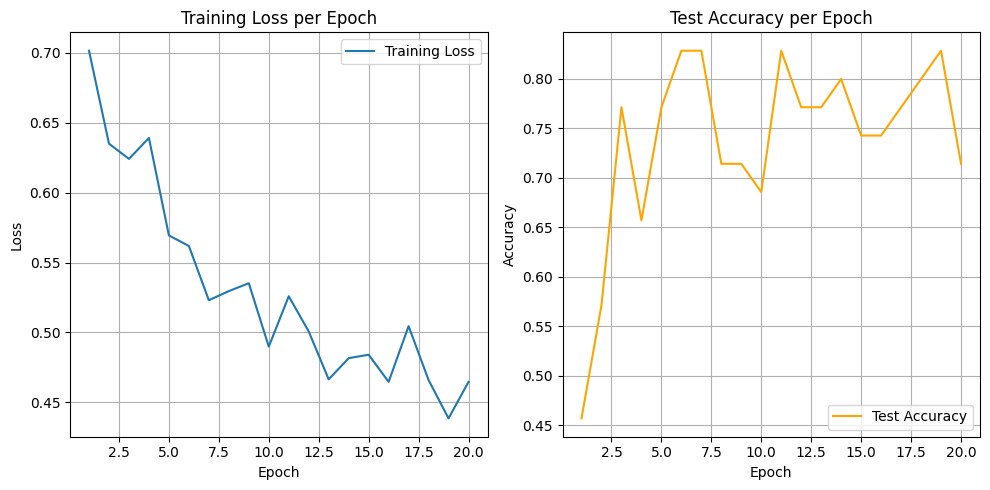

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_acc_values, label='Test Accuracy', color='orange')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Testing**

In [ ]:
import kagglehub

new_dataset_path = kagglehub.dataset_download("eneskosar19/happy-or-sad-binary-image-classification")

print("Path to new dataset files:", new_dataset_path)

In [ ]:
set_seed(42)

new_dataset = datasets.ImageFolder(
    root=new_dataset_path + "/face_classification",
    transform=transform
)

print(f"New dataset length: {len(new_dataset)}")
print(f"New dataset classes: {new_dataset.classes}")

Displaying predictions for 2 random images from the new dataset:

Sample 1: Original image path: /kaggle/input/happy-or-sad-binary-image-classification/face_classification/sad_person_face/bearded-guy-brown-coat-with-sad-face_1258-6716.jpg
Actual label: sad_person_face


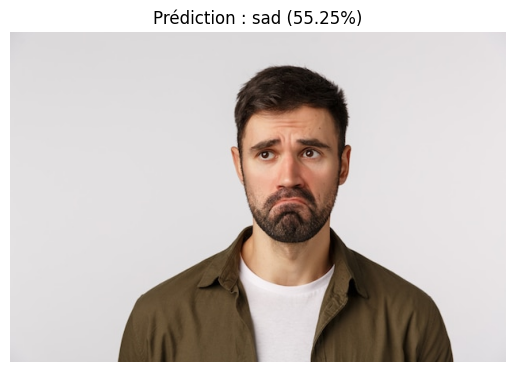


Sample 2: Original image path: /kaggle/input/happy-or-sad-binary-image-classification/face_classification/sad_person_face/ive-emotion-isolated-feeling-unhappy-crying-white-studio-background-90813316.jpg
Actual label: sad_person_face


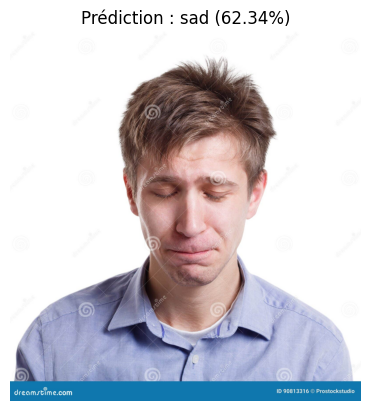

In [ ]:
import random
set_seed(566)

num_samples_to_test = 2


sample_indices = random.sample(range(len(new_dataset)), num_samples_to_test)

print(f"Displaying predictions for {num_samples_to_test} random images from the new dataset:")


for i, idx in enumerate(sample_indices):

    image_file_path = new_dataset.samples[idx][0]
    true_label_idx = new_dataset.samples[idx][1]
    true_label = new_dataset.classes[true_label_idx]

    print(f"\nSample {i+1}: Original image path: {image_file_path}")
    print(f"Actual label: {true_label}")

    predicted_label = predict_emotion(image_file_path)
